### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 30th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [1]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

In [2]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(___, ___, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(___.flatten(), ___.flatten(), ___, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

NameError: name 'plt' is not defined

In [ ]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

## Part 1:

In [3]:
# Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. 
#The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. 
#Make a 2-panel scatter plot of the labels versus each feature.

#importing tools
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn

data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw7_data_1.npy')
data.shape

(500, 4)

In [4]:
X = data[:,:2] #first two columns (0,1) are data X
y = data[:,2]  #third column is labels y
yerr = data[:,3] #fourth column in uncertainties on the labels, yerr

Text(0, 0.5, 'Data Labels')

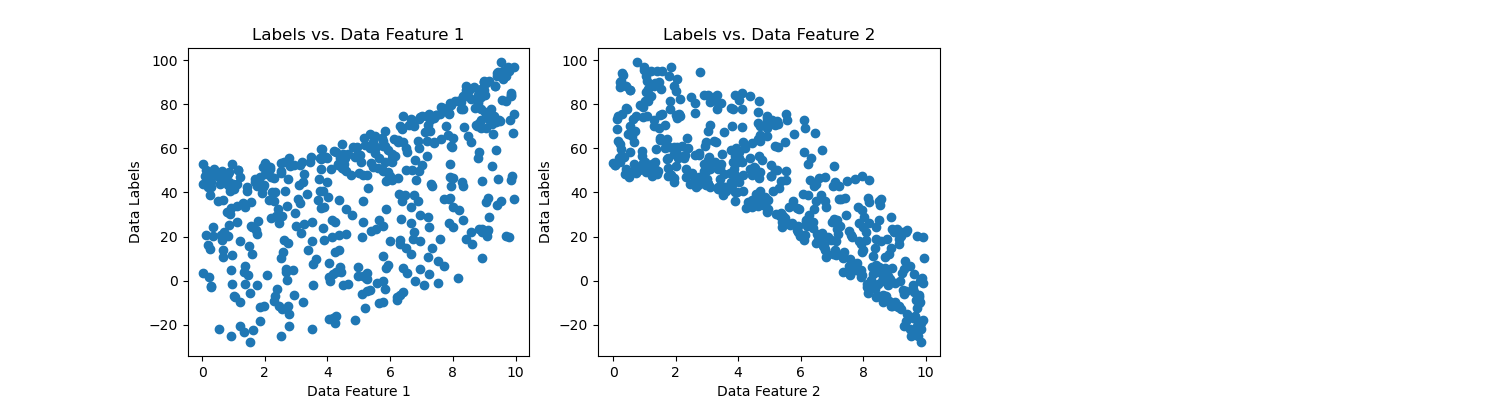

In [5]:
#plotting scatterplot
#plt.scatter(X[:,0],X[:,1], c=y)

#making two subplots with X[0] vs y and X[1] vs y
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131)
ax1.scatter(X[:,0],y)
ax1.set_title('Labels vs. Data Feature 1')

ax1.set_xlabel('Data Feature 1')
ax1.set_ylabel('Data Labels')

ax2 = fig.add_subplot(132)
ax2.scatter(X[:,1],y)
ax2.set_title('Labels vs. Data Feature 2')

ax2.set_xlabel('Data Feature 2')
ax2.set_ylabel('Data Labels')


## Part 2:

In [6]:
#Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). 
#Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, 
# and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?

from astroML.linear_model import LinearRegression

/home/nowickr/miniconda3/envs/astro8070/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [7]:
#distinguishing the two features
x1 = X[:,0]
x2 = X[:,1]

In [8]:
#making prediction grid
Xgrid = np.empty((50,2))
Xgrid[:,0] = np.linspace(x1.min(),x1.max(),50)
Xgrid[:,1] = np.linspace(x2.min(),x2.max(),50)

In [9]:
#finding the best fit model
model = LinearRegression()
mx1 = model.fit(X, y, yerr)
print(mx1.coef_)#, mx2.coef_)

[57.10102323  4.94873016 -8.30023407]


In [10]:
#making prediction
y_pred = mx1.predict(Xgrid)

In [11]:
print(y_pred)

[57.2126088  56.52936286 55.84611693 55.16287099 54.47962505 53.79637911
 53.11313318 52.42988724 51.7466413  51.06339537 50.38014943 49.69690349
 49.01365756 48.33041162 47.64716568 46.96391975 46.28067381 45.59742787
 44.91418194 44.230936   43.54769006 42.86444413 42.18119819 41.49795225
 40.81470631 40.13146038 39.44821444 38.7649685  38.08172257 37.39847663
 36.71523069 36.03198476 35.34873882 34.66549288 33.98224695 33.29900101
 32.61575507 31.93250914 31.2492632  30.56601726 29.88277132 29.19952539
 28.51627945 27.83303351 27.14978758 26.46654164 25.7832957  25.10004977
 24.41680383 23.73355789]


Text(0, 0.5, 'Data Labels')

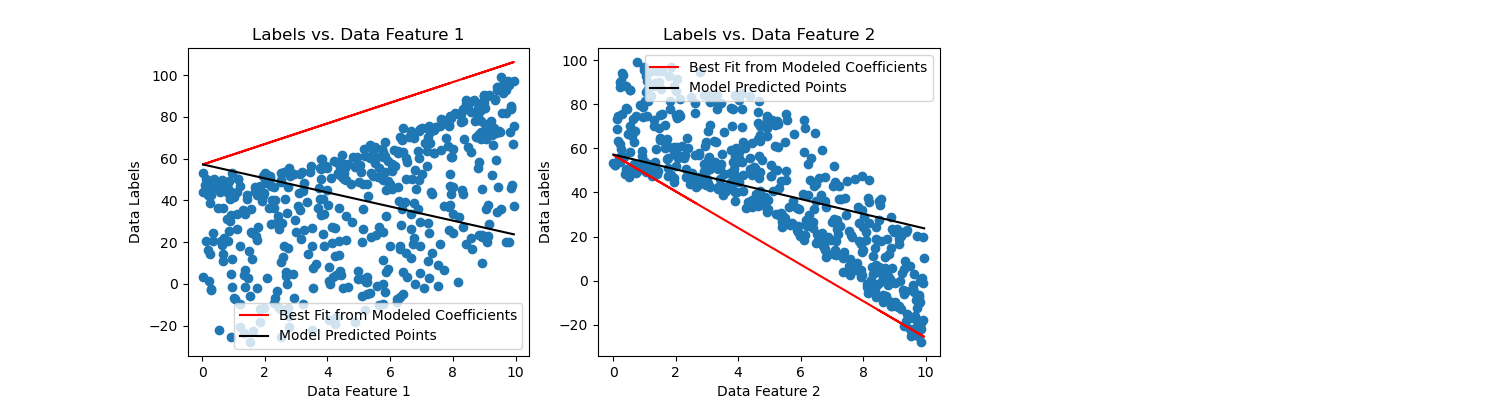

In [12]:
#plotting the best fit model on a duplcate of the plot from 1
#making two subplots with X[0] vs y and X[1] vs y
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(131)
ax1.scatter(x1,y)
ax1.plot(x1, (mx1.coef_[0] + mx1.coef_[1]*x1), color='r', label='Best Fit from Modeled Coefficients')  #adding best fit line???
ax1.plot(Xgrid[:,0],y_pred, color='k', label='Model Predicted Points')
ax1.set_title('Labels vs. Data Feature 1')
ax1.legend()

ax1.set_xlabel('Data Feature 1')
ax1.set_ylabel('Data Labels')

ax2 = fig.add_subplot(132)
ax2.scatter(x2,y)
ax2.plot(x2, (mx1.coef_[0] + mx1.coef_[2]*x2), color='r', label='Best Fit from Modeled Coefficients')  #adding best fit line???
ax2.plot(Xgrid[:,1],y_pred, color='k', label='Model Predicted Points')
ax2.set_title('Labels vs. Data Feature 2')

ax2.legend()
ax2.set_xlabel('Data Feature 2')
ax2.set_ylabel('Data Labels')

## Part 3:

In [13]:
#Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, 
# and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

X1grid, X2grid = np.meshgrid(Xgrid[:,0],Xgrid[:,1])
fullgrid = np.vstack((X1grid.flatten(),X2grid.flatten())).T
print(fullgrid.shape)

#make prediction using existing model mx1
y_pred_grid = mx1.predict(fullgrid)
print(y_pred_grid)

(2500, 2)
[57.2126088  58.21412487 59.21564093 ... 21.73052576 22.73204183
 23.73355789]


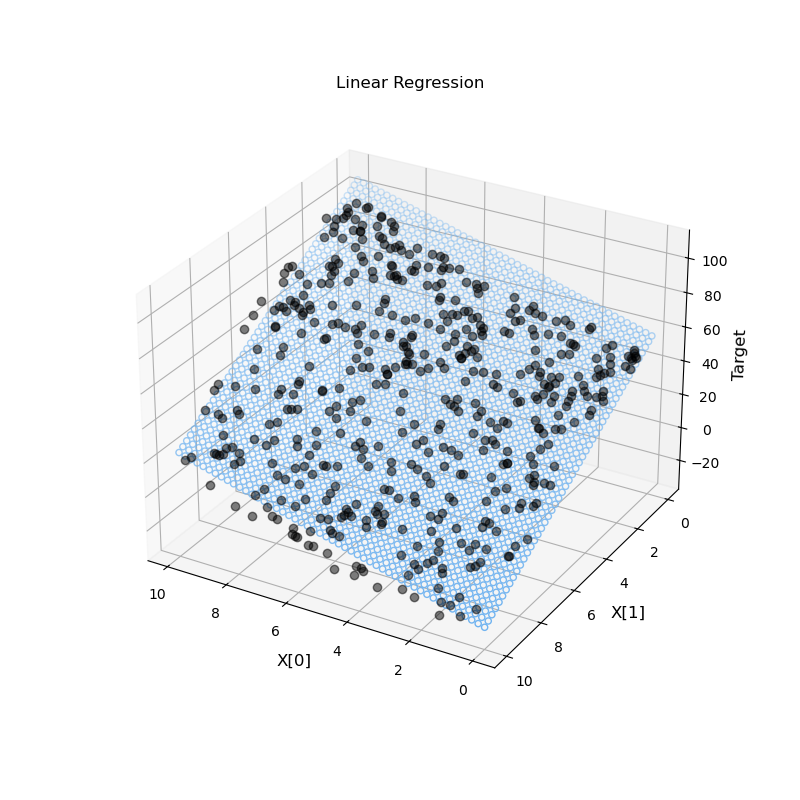

In [14]:
#MAKING PLOT

#plotting best fit hyperplane from previous model fit
zz = mx1.coef_[0] + x1*mx1.coef_[1] + x2*mx1.coef_[2]
#print(zz)


# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

#plotting data
ax.plot(x1, x2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#plotting predicted fit
ax.scatter(X1grid.flatten(), X2grid.flatten(), y_pred_grid, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Linear Regression')
ax.view_init(elev=28, azim=120)

#------------------------------------------

## Part 4:

In [15]:
#Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
#```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
#```
#What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. 
#Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? 
#*(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [16]:
print(ridge_params)#['alpha'])

{'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}


In [17]:
#Using GridSearchCV

#establishing "grid" with Ridge fit model
grid = GridSearchCV(Ridge(), {'alpha': ridge_params['alpha'], 'solver': ridge_params['solver']})
#fit the model with our data features, reshaped to accomodate grid.fit
grid.fit(X,y)
param_opt = grid.best_params_
score_opt = grid.best_score_
print('Best alpha, best solver:', param_opt)
print('Best score:', score_opt)

Best alpha, best solver: {'alpha': 1.0, 'solver': 'svd'}
Best score: 0.9290800590702192


In [18]:
#using GridSearchCV'ed params to do Ridge fit
ridge_w_bestparams = Ridge(alpha=param_opt['alpha'], solver=param_opt['solver'])
ridge_w_bestparams.fit(X,y,yerr)
y_pred_ridge = ridge_w_bestparams.predict(fullgrid)
print(y_pred_ridge)

[56.57329986 57.56491796 58.55653606 ... 22.14611825 23.13773636
 24.12935446]


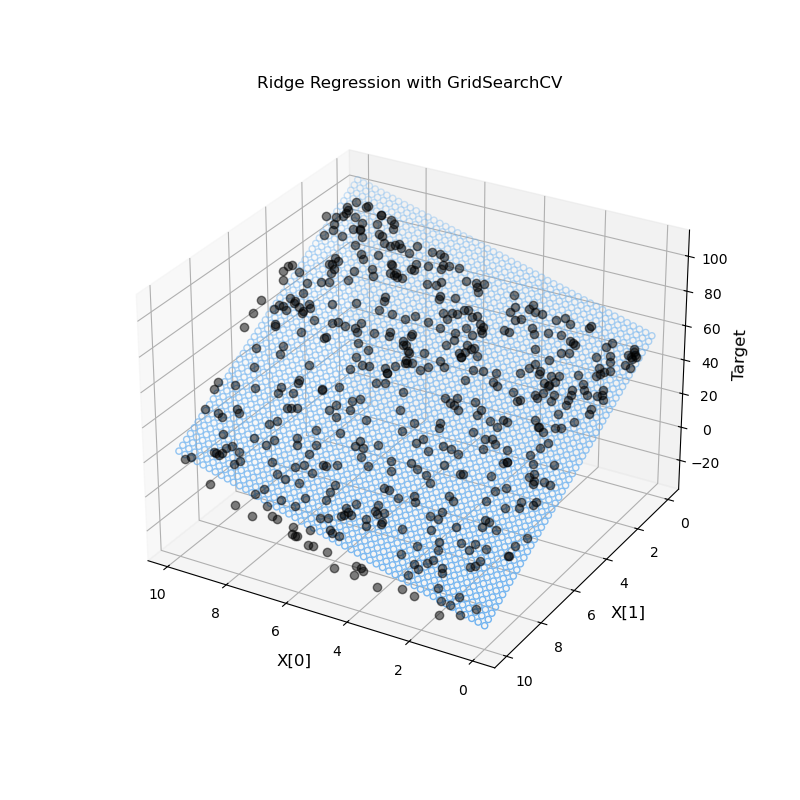

In [19]:
#plotting it
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(x1, x2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X1grid.flatten(), X2grid.flatten(), y_pred_ridge, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Ridge Regression with GridSearchCV')
ax.view_init(elev=28, azim=120)

In [20]:
#Trying with RidgeCV

#establishing "grid" with Ridge fit model
grid_r = RidgeCV(alphas=ridge_params['alpha'], gcv_mode='svd')
#fit the model with our data features, reshaped to accomodate grid.fit
grid_r.fit(X,y,yerr)
y_pred_ridge_cv = ridge_w_bestparams.predict(fullgrid)
print(y_pred_ridge_cv)

#returning cross-validated alpha
alp_rcv = grid_r.alpha_
print(alp_rcv)

[56.57329986 57.56491796 58.55653606 ... 22.14611825 23.13773636
 24.12935446]
1.0


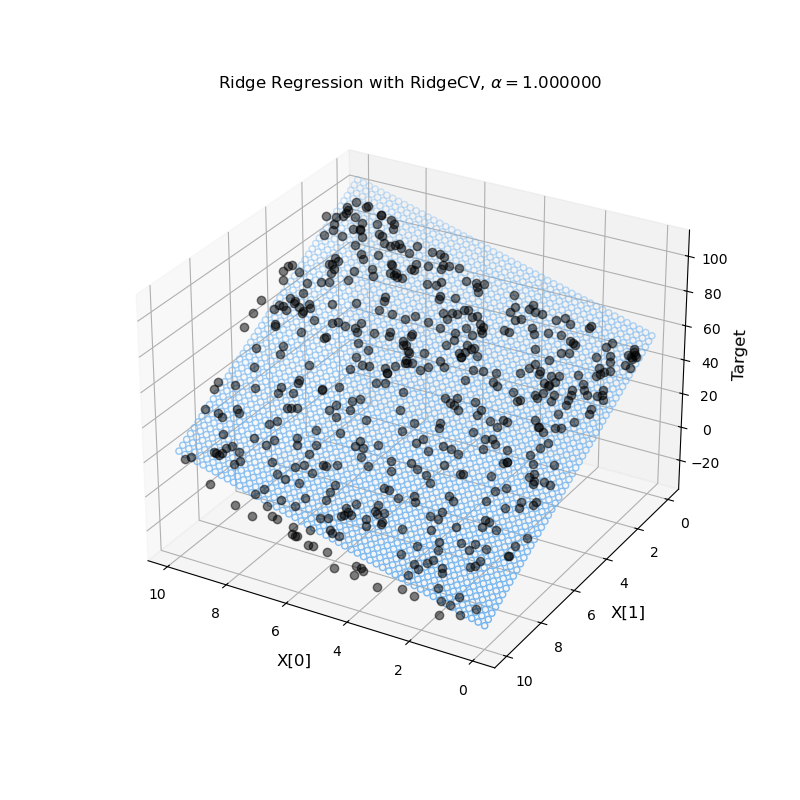

In [21]:
#plotting RidgeCV
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(x1, x2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X1grid.flatten(), X2grid.flatten(), y_pred_ridge_cv, #changing predicted y's here
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Ridge Regression with RidgeCV, $\\alpha = %f$' %alp_rcv)
ax.view_init(elev=28, azim=120)

## Part 5:

In [22]:
#Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. 
#*(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [23]:
#running with no yerr; from lecture 18

gp_noerr = GaussianProcessRegressor(#kernel=kernel, #default kernel, so this can be ignored
                               random_state=0, normalize_y=True)
gp_noerr.fit(X,y) #fitting to data
f1, f1_err = gp_noerr.predict(fullgrid, 
                         return_std=True) #making prediction

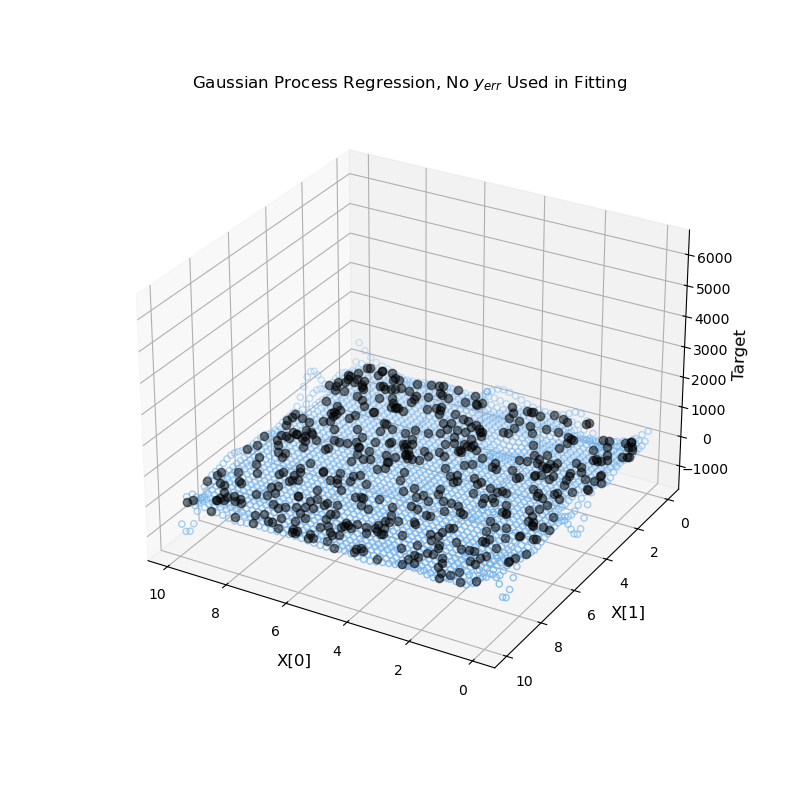

In [24]:
#plotting GPR with no err accounted for
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(x1, x2, y, color='k', #plotting original data
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X1grid.flatten(), X2grid.flatten(), f1, #changing predicted y's here
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Gaussian Process Regression, No $y_{err}$ Used in Fitting')
ax.view_init(elev=28, azim=120)

<font color='lime'> It's hard to tell how well this fits the grid at the center given the scale, but it is clear that the edges suffer from extremely high variance when we fit without accounting for yerr </font>

In [25]:
#running with yerr; from lecture 18

gp_err = GaussianProcessRegressor(#kernel=kernel, #default kernel, so this can be ignored
                               alpha=(yerr/y)**2, #enabling this alpha will allow us to account for yerr
                               random_state=0, normalize_y=True)
gp_err.fit(X,y) #fitting to data
f2, f2_err = gp_err.predict(fullgrid, 
                         return_std=True) #making prediction

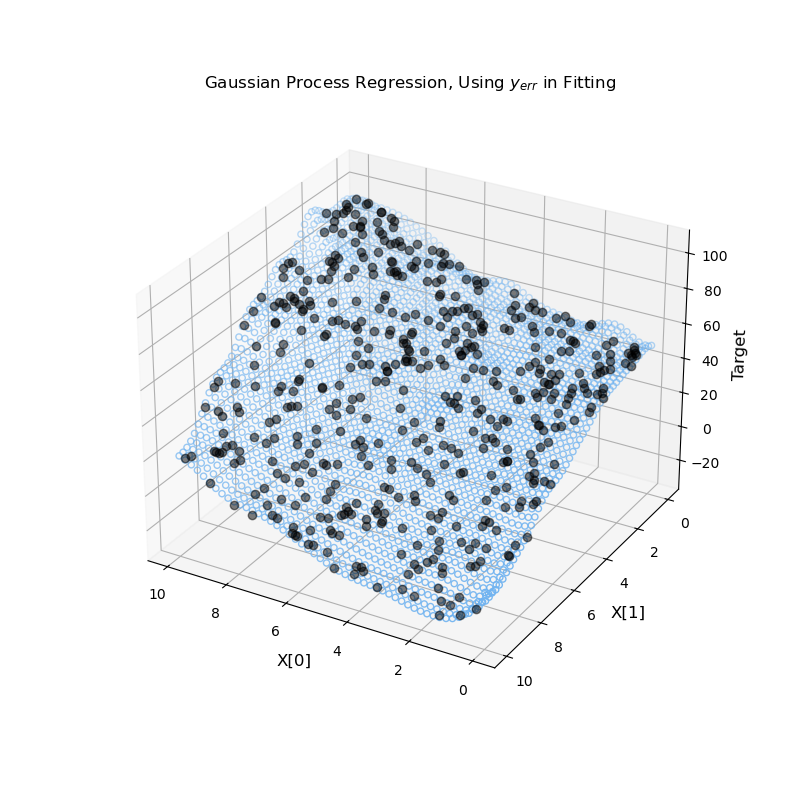

In [26]:
#plotting GPR with err accounted for
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(x1, x2, y, color='k', #plotting original data
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X1grid.flatten(), X2grid.flatten(), f2, #changing predicted y's here
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Gaussian Process Regression, Using $y_{err}$ in Fitting')
ax.view_init(elev=28, azim=120)

<font color='lime'> By setting the $\alpha$ parameter to be $(\frac{y_{err}}{y})^{2}$, we were able to account for the $y_{err}$ in our fit, which appears to have significantly reduced the spread of fitted points near the edges of the grid; the fit is better. </font>

## Part 6:

In [27]:
#Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid,
# and visualize interactively as before. How does this look compared to the linear model and GPR models?
from astroML.linear_model import PolynomialRegression

In [28]:
#from lecture 17
degree = 4
polymodel = PolynomialRegression(degree=degree) # fitting 4th degree polynomial
polymodel.fit(X, y, yerr)

#printing coefficients
print('Polynomial Best-Fit Coefficients:', polymodel.coef_)

#predicting on meshgrid
y_poly = polymodel.predict(fullgrid)

Polynomial Best-Fit Coefficients: [ 4.99887582e+01  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842379e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]


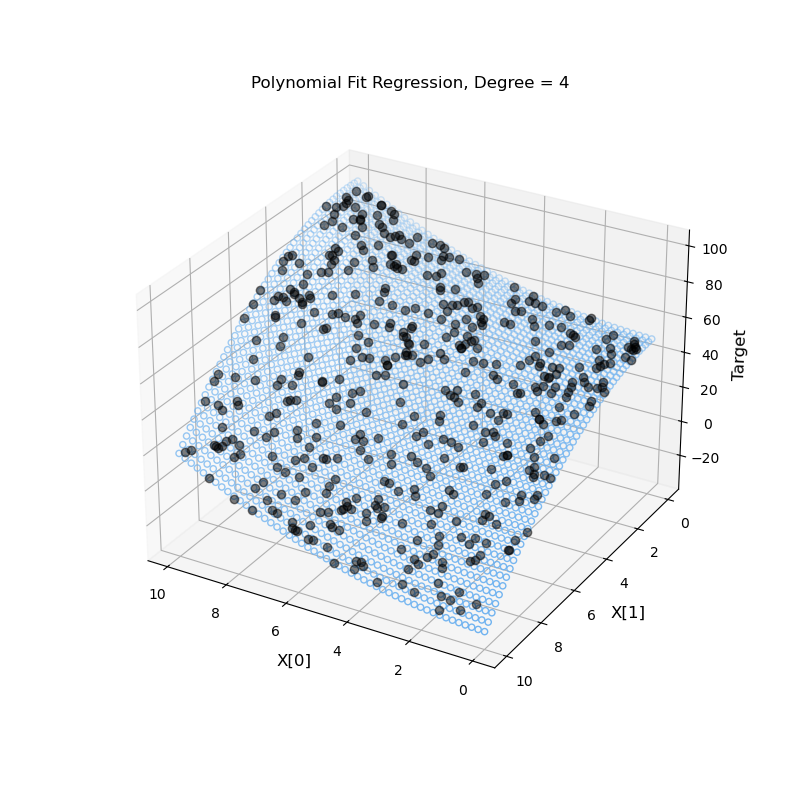

In [29]:
#MAKING POLYNOMIAL FIT PLOT

#plotting best fit hyperplane from previous model fit
zz = polymodel.coef_[0] + x1*polymodel.coef_[1] + x2*polymodel.coef_[2]
#print(zz)


# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

#plotting data
ax.plot(x1, x2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#plotting predicted fit
ax.scatter(X1grid.flatten(), X2grid.flatten(), y_poly, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Polynomial Fit Regression, Degree = %i' %degree)
ax.view_init(elev=28, azim=120)

#------------------------------------------

<font color='lime'> The polynomial fit curve appears to be a much better fit than the linear model, with fitted points lying closer to real ones. It also appears smoother than the GPR fit, which has a bumpier texture that may be indicative of overfitting. </font>

## Part 7:

In [30]:
#Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
#- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself 
#   as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out 
#   `yerr` as well by just providing this as another array to `train_test_split`.
#- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. 
#   Plot the rms errors and BIC values as a function of the polynomial degree. 
#- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. 
#   Predict the labels of the held-out test set, and finally compute the testing rms error.

from sklearn.model_selection import train_test_split

In [40]:
#creating training/testing sets
X_train, X_test, y_train, y_test, yerr_train, yerr_test = train_test_split(X,y,yerr, test_size=0.2)
print(len(X_train), len(y_train))
#splitting training again to make cross validation set
X_train, X_cv, y_train, y_cv, yerr_train, yerr_cv = train_test_split(X_train,y_train,yerr_train, test_size=0.2)
print(len(X_train), len(X_test), len(X_cv))

400 400
320 100 80


In [42]:
#creating training/testing sets
data_train, data_test = train_test_split(data, test_size=0.2)

#splitting training again to make cross validation set
data_train, data_cv = train_test_split(data_train, test_size=0.2)

X_train = data_train[:,:2]
X_test = data_test[:,:2]
X_cv = data_cv[:,:2]
y_train = data_train[:,2]
y_test = data_test[:,2]
y_cv = data_cv[:,2]
yerr_train = data_train[:,3]
yerr_test = data_test[:,3]
yerr_cv = data_cv[:,3]
print(len(X_train), len(X_test), len(X_cv))

320 100 80


In [43]:
#- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. 
#   Plot the rms errors and BIC values as a function of the polynomial degree.

#FROM LECTURE 17:
d = np.arange(1, 11) #potenital choices of degree
#making empty arrays to put values in
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

#iterate over degrees to get rms errors
for i in range(len(d)):
    p = PolynomialRegression(d[i])
    p.fit(X_train, y_train, yerr_train)
    #p = np.polyfit(X, y, d[i])
    #training_err[i] = np.sqrt(np.sum((np.polyval(p.coef_, X_train) - y_train) ** 2)        #here, polyfit and polyval used in lecture want a 1D input, not a 2D grid, so i am using Polynomial Regresion
    training_err[i] = np.sqrt(np.sum((p.predict(X_train) - y_train) ** 2)
                              / len(y_train))
    #crossval_err[i] = np.sqrt(np.sum((np.polyval(p, X_cv) - y_cv) ** 2)
    crossval_err[i] = np.sqrt(np.sum((p.predict(X_cv) - y_cv) ** 2)
                              / len(y_cv))

#calculating BIC values based on errors
BIC_train = np.sqrt(len(y)) * training_err  + d * np.log(len(y))
BIC_crossval = np.sqrt(len(y)) * crossval_err  + d * np.log(len(y))

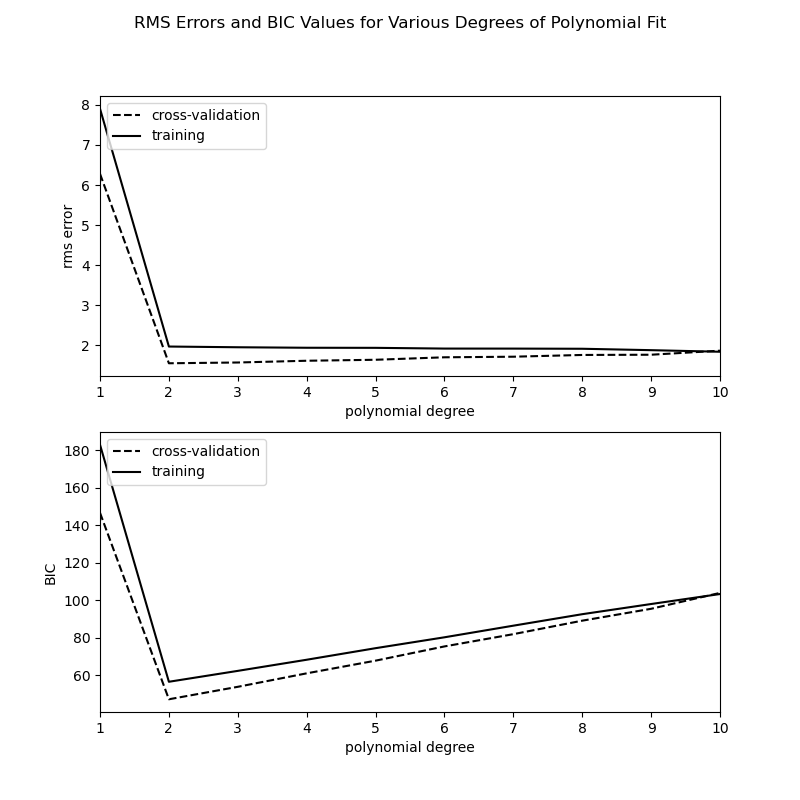

In [44]:
#plotting based on lecture 17
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
#ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(1, 10)
#ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(1, 10)
#ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.suptitle('RMS Errors and BIC Values for Various Degrees of Polynomial Fit')
plt.show()

In [45]:
#- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. 
#   Predict the labels of the held-out test set, and finally compute the testing rms error.
d_opt = 2
polymodel_opt = PolynomialRegression(degree=d_opt) # fitting 4th degree polynomial
polymodel_opt.fit(X_train, y_train, yerr_train)

#printing coefficients
print('Polynomial Best-Fit Coefficients:', polymodel.coef_)

#predicting on meshgrid
y_pred_test = polymodel_opt.predict(X_test)

Polynomial Best-Fit Coefficients: [ 4.99887582e+01  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842379e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]


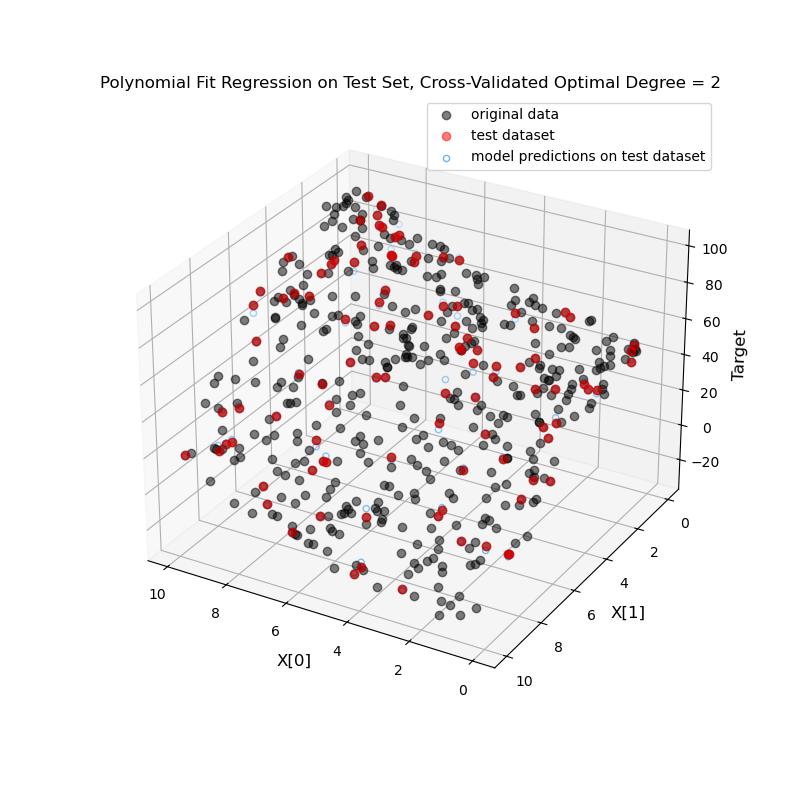

In [47]:
#plotting predictions on test set
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

#plotting data
ax.plot(x1, x2, y, color='k', label='original data', #original data
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.plot(X_test[:,0], X_test[:,1], y_test, color='r', label='test dataset', #test data
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#plotting predicted fit
ax.scatter(X_test[:,0].flatten(), X_test[:,1].flatten(), y_pred_test, label='model predictions on test dataset', #prediction on test set
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Polynomial Fit Regression on Test Set, Cross-Validated Optimal Degree = %i' %d_opt)
ax.view_init(elev=28, azim=120)

plt.legend()

In [48]:
#test rms error
testing_err = np.sqrt(np.sum(((y_pred_test) - y_test) ** 2) / len(y_test))
print('Testing Set RMS Error:', testing_err)

Testing Set RMS Error: 2.035667932265583


<font color='lime'> This is not good! This fit is basically just a random scatterplot, with no resemblance to the original data at all! However, it seems the predictions (blue) match the test dataset (red) provided to the fitting model. I tried two different ways of employing the sklearn train_test_split function on the data -- first as separate variables and then as a combined dataset to be splot later in case it did not keep points together, but this does not seem to have been the case. 

Below, I applied the same procedure (same train_test_split, same prediction model trained on the training set) but instead asked it to fit on the meshgrid used in the previous problems. Here, the fit looks good. This leads me to believe there is an issue with the test sets.

***Running this again after turning it in, it seems to have worked once I properly renamed X_test. Whoops!***

In [49]:
#instead of giving it the test-train-split data to fit, fit it to the meshgrid (still with model trained on training split data!)
y_pred_test2 = polymodel_opt.predict(fullgrid)

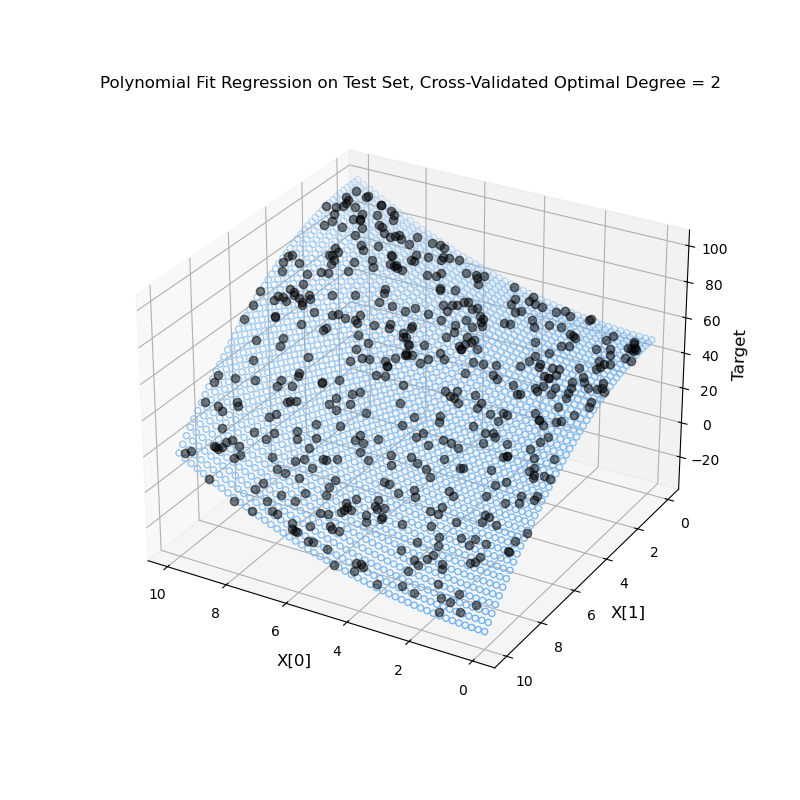

In [50]:
#plotting predictions on test set
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

#plotting data
ax.plot(x1, x2, y, color='k', #original data
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#plotting predicted fit
ax.scatter(X1grid.flatten(), X2grid.flatten(), y_pred_test2, #prediction on test set
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.set_title('Polynomial Fit Regression on Test Set, Cross-Validated Optimal Degree = %i' %d_opt)
ax.view_init(elev=28, azim=120)